# **IMPORTADO DE MÓDULOS/PULSOS/FUNCIONES**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import tensorflow as tf
tf.version.VERSION

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, concatenate
from tensorflow.keras import initializers
from keras.regularizers import l2
from keras.optimizers import Adam

In [2]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

In [3]:
from functions import momentos, create_set, pulso, delay_pulse_pair, gauss, gauss_fit
from Models import model_definition_four_inputs

# **PREPROCESSING**

In [4]:
#--------------------------------Interpolar pulsos reales---------------------------------
input = V28
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo,V28, kind='cubic', axis=1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo,V55, kind='cubic', axis=1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo,V82, kind='cubic', axis=1)
new_V82 = interp_func_V82(tiempo_new)


print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


In [5]:
INPUT = np.concatenate((new_V55,new_V28,new_V82),axis=0)
Ncasos = INPUT.shape[0]
Ncasos_sim = 3000
Nc = 2

tt=np.linspace(0,600,600)   #time step of 0.2ns
t_shift = 8 #In time steps
t = np.linspace(0,Nt,Nt_new)
t0 = 65 + np.random.randint(8, size=Ncasos_sim)

# **GET CLOSEST PULSE TO EACH**

In [6]:
set_V28_dec0 = create_set(new_V28, channel = 0)
set_V55_dec0 = create_set(new_V55, channel = 0)
set_V82_dec0 = create_set(new_V82, channel = 0)
full_set_dec0 = np.concatenate((set_V28_dec0, set_V55_dec0, set_V82_dec0), axis = 0)

set_V28_dec1 = create_set(new_V28, channel = 1)
set_V55_dec1 = create_set(new_V55, channel = 1)
set_V82_dec1 = create_set(new_V82, channel = 1)
full_set_dec1 = np.concatenate((set_V28_dec1, set_V55_dec1, set_V82_dec1), axis = 0)

# **DETECTOR 0**

In [12]:
#--------------------------------- Detector 0 definitions -------------------------
tau_rise_dec0 = 15
tau_drop_dec0 = 150

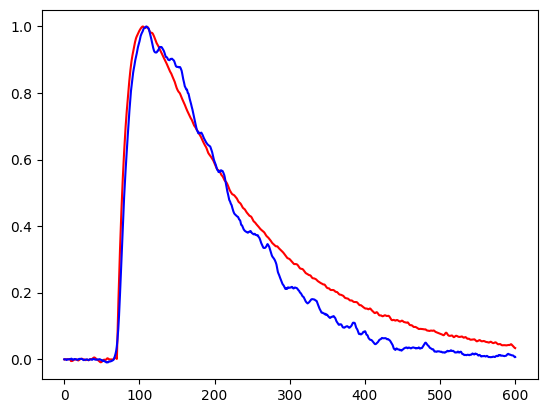

In [13]:
pulso_original = pulso(t,70, tau_rise = tau_rise_dec0, tau_drop = tau_drop_dec0)


plt.plot(tiempo_new, pulso_original, 'r-')
plt.plot(tiempo_new, new_V28[0,:,0], 'b-')

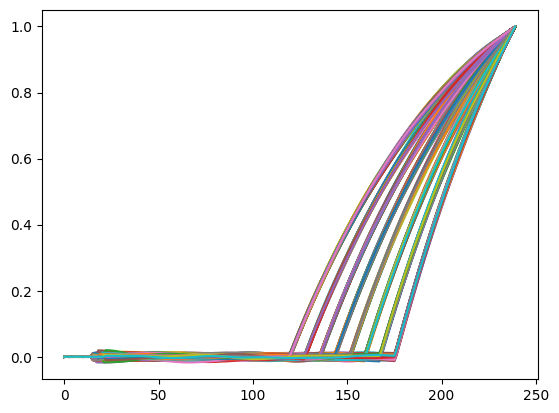

In [17]:
INPUT_dec0 = np.zeros((Ncasos_sim,Nt_new,Nc))

for i in range(INPUT_dec0.shape[0]):
  centro = t0[i]
  PULSO = pulso(t,centro)
  plt.plot(PULSO)
  INPUT_dec0[i,:,0] = PULSO
  INPUT_dec0[i,:,1] = PULSO

full_set_PULSO_dec0 = create_set(INPUT_dec0, channel = 0)

In [18]:
INPUT2_dec0 = np.zeros((full_set_dec0.shape[0],full_set_dec0.shape[1], 4))
REF_dec0_closest_delayed = np.zeros((full_set_dec0.shape[0],),dtype=np.float32)
REF_dec0_og_delayed = np.zeros((full_set_dec0.shape[0],),dtype=np.float32)

NRD0 = np.random.randint(20, size=full_set_dec0.shape[0])
NRD1 = np.random.randint(20, size=full_set_dec0.shape[0])
NRD2 = np.random.randint(20, size=full_set_dec0.shape[0])

for i in range(full_set_dec0.shape[0]):
  N0 = NRD0[i]
  noise00 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise00, sigma=10)
  INPUT2_dec0[i,:,0]=np.roll(full_set_dec0[i,:,0],N0)
  INPUT2_dec0[i,:,0] = INPUT2_dec0[i,:,0]
  INPUT2_dec0[i,0:N0,0] = smoothed_noise[0:N0]

  INPUT2_dec0[i,:,2]=np.roll(full_set_dec0[i,:,1],N0)
  INPUT2_dec0[i,:,2] = INPUT2_dec0[i,:,2]
  INPUT2_dec0[i,0:N0,2] = smoothed_noise[0:N0]

  N1 = NRD1[i]
  noise11 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise11, sigma=10)
  INPUT2_dec0[i,:,1]=np.roll(full_set_dec0[i,:,0],N1)
  INPUT2_dec0[i,:,1] = INPUT2_dec0[i,:,1] + smoothed_noise
  INPUT2_dec0[i,0:N1,1] = smoothed_noise[0:N1]

  N2 = NRD2[i]
  noise22 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise22, sigma=10)
  INPUT2_dec0[i,:,3]=np.roll(full_set_dec0[i,:,1],N2)
  INPUT2_dec0[i,:,3] = INPUT2_dec0[i,:,3] + smoothed_noise
  INPUT2_dec0[i,0:N2,3] = smoothed_noise[0:N2]

  REF_dec0_og_delayed[i]=new_time_step*(N0-N1)  #in ns (t_shift is defined above)
  REF_dec0_closest_delayed[i]=new_time_step*(N0-N2)  #in ns (t_shift is defined above)

#-----------------------------------------------------------------------------------------------------------
INPUT3_dec0 = np.zeros((full_set_PULSO_dec0.shape[0],full_set_PULSO_dec0.shape[1], 4))
REF_sim_dec0_closest_delayed = np.zeros((full_set_PULSO_dec0.shape[0],),dtype=np.float32)
REF_sim_dec0_og_delayed = np.zeros((full_set_PULSO_dec0.shape[0],),dtype=np.float32)


NRD0 = np.random.randint(20, size=full_set_PULSO_dec0.shape[0])
NRD1 = np.random.randint(20, size=full_set_PULSO_dec0.shape[0])
NRD2 = np.random.randint(20, size=full_set_PULSO_dec0.shape[0])

for i in range(full_set_PULSO_dec0.shape[0]):
  N0 = NRD0[i]
  noise00 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise00, sigma=10)
  INPUT3_dec0[i,:,0]=np.roll(full_set_PULSO_dec0[i,:,0],N0)
  INPUT3_dec0[i,:,0] = INPUT3_dec0[i,:,0]
  INPUT3_dec0[i,0:N0,0] = smoothed_noise[0:N0]

  INPUT3_dec0[i,:,2]=np.roll(full_set_PULSO_dec0[i,:,1],N0)
  INPUT3_dec0[i,:,2] = INPUT3_dec0[i,:,2]
  INPUT3_dec0[i,0:N0,2] = smoothed_noise[0:N0]

  N1 = NRD1[i]
  noise11 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise11, sigma=10)
  INPUT3_dec0[i,:,1]=np.roll(full_set_PULSO_dec0[i,:,0],N1)
  INPUT3_dec0[i,:,1] = INPUT3_dec0[i,:,1] + smoothed_noise
  INPUT3_dec0[i,0:N1,1] = smoothed_noise[0:N1]

  N2 = NRD2[i]
  noise22 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise22, sigma=10)
  INPUT3_dec0[i,:,3]=np.roll(full_set_PULSO_dec0[i,:,1],N2)
  INPUT3_dec0[i,:,3] = INPUT3_dec0[i,:,3] + smoothed_noise
  INPUT3_dec0[i,0:N2,3] = smoothed_noise[0:N2]

  REF_sim_dec0_og_delayed[i]=new_time_step*(N0-N1)  #in ns (t_shift is defined above)
  REF_sim_dec0_closest_delayed[i]=new_time_step*(N0-N2)  #in ns (t_shift is defined above))

trainX_dec0 = np.concatenate((INPUT2_dec0, INPUT3_dec0), axis = 0)

REF_real_train_dec0 = np.vstack((REF_dec0_og_delayed, REF_dec0_closest_delayed)).T #shape = [batch_size, 2]
REF_sim_train_dec0 = np.vstack((REF_sim_dec0_og_delayed, REF_sim_dec0_closest_delayed)).T #shape = [batch_size, 2]
REF_train_dec0 = np.concatenate((REF_real_train_dec0, REF_sim_train_dec0), axis = 0)

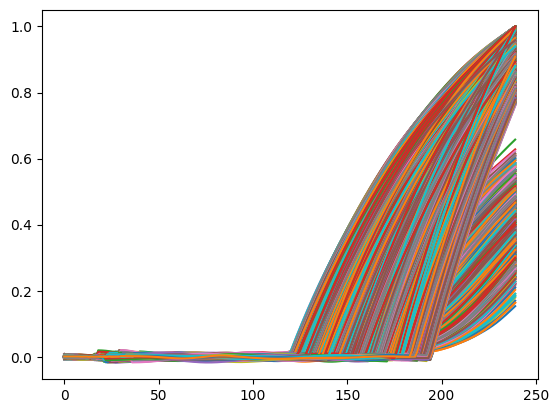

In [19]:
for i in range(trainX_dec0.shape[0]):
  plt.plot(trainX_dec0[i,:,0])
  plt.plot(trainX_dec0[i,:,2])

In [20]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0)

min_dec0 = np.min(M_Train_dec0)
max_dec0 = np.max(M_Train_dec0)

M_Train_dec0 = (M_Train_dec0-min_dec0)/(max_dec0 - min_dec0)

NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)

(3736, 12, 4) NM = 12


# **DETECTOR 1**

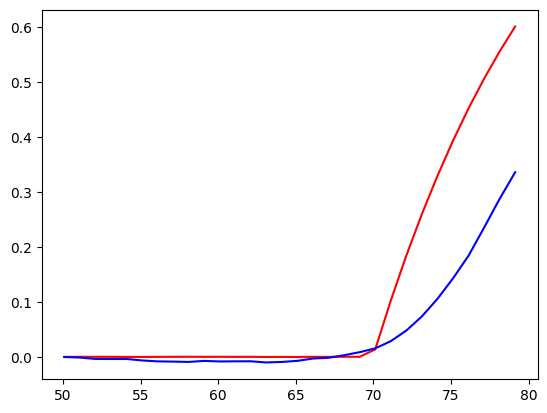

In [22]:
pulso_original = pulso(tt,70)

plt.plot(tt,pulso_original,'r-')
plt.plot(tt,V28,'b-')

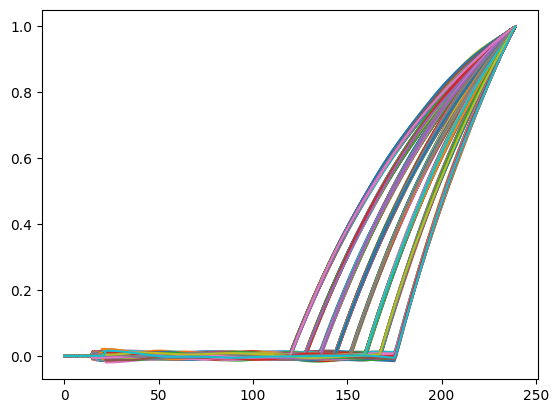

In [24]:
INPUT_dec1 = np.zeros((Ncasos_sim,Nt_new,Nc))

for i in range(INPUT_dec1.shape[0]):
  centro = t0[i]
  PULSO = pulso(t,centro)
  plt.plot(PULSO)
  INPUT_dec1[i,:,0] = PULSO
  INPUT_dec1[i,:,1] = PULSO
  
full_set_PULSO_dec1 = create_set(INPUT_dec1, channel = 0)

In [25]:
INPUT2_dec1 = np.zeros((full_set_dec1.shape[0],full_set_dec1.shape[1], 4))
REF_dec1_closest_delayed = np.zeros((full_set_dec1.shape[0],), dtype = np.float32)
REF_dec1_og_delayed = np.zeros((full_set_dec1.shape[0],), dtype = np.float32)

NRD0 = np.random.randint(20, size = full_set_dec1.shape[0])
NRD1 = np.random.randint(20, size = full_set_dec1.shape[0])
NRD2 = np.random.randint(20, size = full_set_dec1.shape[0])

for i in range(full_set_dec1.shape[0]):
  N0 = NRD0[i]
  noise00 = np.random.normal(scale = 0.01, size = new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise00, sigma = 10)
  INPUT2_dec1[i,:,0]=np.roll(full_set_dec1[i,:,0],N0)
  INPUT2_dec1[i,:,0] = INPUT2_dec1[i,:,0]
  INPUT2_dec1[i,0:N0,0] = smoothed_noise[0:N0]

  INPUT2_dec1[i,:,2]=np.roll(full_set_dec0[i,:,1],N0)
  INPUT2_dec1[i,:,2] = INPUT2_dec1[i,:,2]
  INPUT2_dec1[i,0:N0,2] = smoothed_noise[0:N0]

  N1 = NRD1[i]
  noise11 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise11, sigma=10)
  INPUT2_dec1[i,:,1]=np.roll(full_set_dec1[i,:,0],N1)
  INPUT2_dec1[i,:,1] = INPUT2_dec1[i,:,1] + smoothed_noise
  INPUT2_dec1[i,0:N1,1] = smoothed_noise[0:N1]

  N2 = NRD2[i]
  noise22 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise22, sigma=10)
  INPUT2_dec1[i,:,3]=np.roll(full_set_dec1[i,:,1],N2)
  INPUT2_dec1[i,:,3] = INPUT2_dec1[i,:,3] + smoothed_noise
  INPUT2_dec1[i,0:N2,3] = smoothed_noise[0:N2]

  REF_dec1_og_delayed[i]=new_time_step*(N0-N1)  #in ns (t_shift is defined above)
  REF_dec1_closest_delayed[i]=new_time_step*(N0-N2)  #in ns (t_shift is defined above)

#-----------------------------------------------------------------------------------------------------------
INPUT3_dec1 = np.zeros((full_set_PULSO_dec1.shape[0],full_set_PULSO_dec1.shape[1], 4))
REF_sim_dec1_closest_delayed = np.zeros((full_set_PULSO_dec1.shape[0],),dtype=np.float32)
REF_sim_dec1_og_delayed = np.zeros((full_set_PULSO_dec1.shape[0],),dtype=np.float32)


NRD0 = np.random.randint(20, size=full_set_PULSO_dec1.shape[0])
NRD1 = np.random.randint(20, size=full_set_PULSO_dec1.shape[0])
NRD2 = np.random.randint(20, size=full_set_PULSO_dec1.shape[0])

for i in range(full_set_PULSO_dec1.shape[0]):
  N0 = NRD0[i]
  noise00 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise00, sigma=10)
  INPUT3_dec1[i,:,0]=np.roll(full_set_PULSO_dec1[i,:,0],N0)
  INPUT3_dec1[i,:,0] = INPUT3_dec1[i,:,0]
  INPUT3_dec1[i,0:N0,0] = smoothed_noise[0:N0]

  INPUT3_dec1[i,:,2]=np.roll(full_set_PULSO_dec1[i,:,1],N0)
  INPUT3_dec1[i,:,2] = INPUT3_dec1[i,:,2]
  INPUT3_dec1[i,0:N0,2] = smoothed_noise[0:N0]

  N1 = NRD1[i]
  noise11 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise11, sigma=10)
  INPUT3_dec1[i,:,1]=np.roll(full_set_PULSO_dec1[i,:,0],N1)
  INPUT3_dec1[i,:,1] = INPUT3_dec1[i,:,1] + smoothed_noise
  INPUT3_dec1[i,0:N1,1] = smoothed_noise[0:N1]

  N2 = NRD2[i]
  noise22 = np.random.normal(scale=0.01, size=new_V28.shape[1])
  smoothed_noise = gaussian_filter1d(noise22, sigma=10)
  INPUT3_dec1[i,:,3]=np.roll(full_set_PULSO_dec1[i,:,1],N2)
  INPUT3_dec1[i,:,3] = INPUT3_dec1[i,:,3] + smoothed_noise
  INPUT3_dec1[i,0:N2,3] = smoothed_noise[0:N2]

  REF_sim_dec1_og_delayed[i]=new_time_step*(N0-N1)  #in ns (t_shift is defined above)
  REF_sim_dec1_closest_delayed[i]=new_time_step*(N0-N2)  #in ns (t_shift is defined above))

trainX_dec1 = np.concatenate((INPUT2_dec1, INPUT3_dec1), axis = 0)

REF_real_train_dec1 = np.vstack((REF_dec1_og_delayed, REF_dec1_closest_delayed)).T #shape = [batch_size, 2]
REF_sim_train_dec1 = np.vstack((REF_sim_dec1_og_delayed, REF_sim_dec1_closest_delayed)).T #shape = [batch_size, 2]
REF_train_dec1 = np.concatenate((REF_real_train_dec1, REF_sim_train_dec1), axis = 0)

In [26]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec1 = momentos(trainX_dec1)

min_dec1 = np.min(M_Train_dec1)
max_dec1 = np.max(M_Train_dec1)

M_Train_dec1 = (M_Train_dec1-min_dec1)/(max_dec1 - min_dec1)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)

(3736, 12, 4) NM = 12


# **FULL TOF**

In [27]:
REFERENCE_PULSE_dec0 = np.tile(new_V55[0,:,0], (new_V82.shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(new_V55[0,:,1], (new_V82.shape[0],2,1)).swapaxes(1,2)

M_REF_dec0 = momentos(REFERENCE_PULSE_dec0)
M_REF_dec0 = (M_REF_dec0 - min_dec0)/(max_dec0-min_dec0)

M_REF_dec1 = momentos(REFERENCE_PULSE_dec1)
M_REF_dec1 = (M_REF_dec1 - min_dec1)/(max_dec1-min_dec1)

In [28]:
M_V28 = momentos(new_V28)
M_V28_norm = np.zeros_like(M_V28)
M_V28_norm[:,:,0] = (M_V28[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V28_norm[:,:,1] = (M_V28[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V28.shape)

M_V55 = momentos(new_V55)
M_V55_norm = np.zeros_like(M_V55)
M_V55_norm[:,:,0] = (M_V55[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V55_norm[:,:,1] = (M_V55[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V55.shape)

M_V82 = momentos(new_V82)
M_V82_norm = np.zeros_like(M_V82)
M_V82_norm[:,:,0] = (M_V82[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V82_norm[:,:,1] = (M_V82[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V82.shape)

(187, 12, 2)
(268, 12, 2)
(281, 12, 2)


In [30]:
def custom_loss(y_true, y_pred):
    outA, outB, outC, outD = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], y_pred[:, 3]

    loss1 = tf.reduce_mean(tf.square(outA - outC))
    loss2 = tf.reduce_mean(tf.square((outA - outB) - y_true[:, 0]))
    loss3 = tf.reduce_mean(tf.square((outC - outD) - y_true[:, 1]))
    std_penalty2 = tf.math.reduce_std((outA - outB) - y_true[:, 0])
    std_penalty3 = tf.math.reduce_std((outC - outD) - y_true[:, 1])

    return loss1 + 500*loss2 + 500*loss3 #+ std_penalty2 + std_penalty3

In [ ]:
epochs = 40
num_semillas = 5

epsilon = []
bias = []
std = []
training_loss_dec0 = []
training_loss_dec1 = []

TOFN_V28_list = []
TOFN_V55_list = []
TOFN_V82_list = []


for i in range(num_semillas):
  #seed_value = 42 + 100*int(i)
  #tf.random.set_seed(seed_value)
  #np.random.seed(seed_value)

  model_dec0 = model_definition_four_inputs(NM = 12, NN = 32, STD_INIT = 1)
  model_dec1 = model_definition_four_inputs(NM = 12, NN = 32, STD_INIT = 1)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate=7e-4)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate=7e-4)

  model_dec0.compile(optimizer=opt_dec0,loss=custom_loss)
  model_dec1.compile(optimizer=opt_dec1,loss=custom_loss)

  MCE = []
  FWHM = []
  resolution = []
  loss_dec0 = []
  loss_dec1 = []
  TOFN_V28_epoch = []
  TOFN_V55_epoch = []
  TOFN_V82_epoch = []

  for epoch in range(epochs):

    history_dec0 = model_dec0.fit(x=[M_Train_dec0[:,:,0], M_Train_dec0[:,:,1], M_Train_dec0[:,:,2], M_Train_dec0[:,:,3]],y = REF_train_dec0, epochs=2, batch_size = 256, shuffle = True, verbose=1)
    history_dec1 = model_dec1.fit(x=[M_Train_dec1[:,:,0], M_Train_dec1[:,:,1], M_Train_dec1[:,:,2], M_Train_dec1[:,:,3]],y = REF_train_dec1, epochs=2, batch_size = 256, shuffle = True, verbose=1)

    loss_dec0.append(history_dec0.history['loss'][-1])
    loss_dec1.append(history_dec1.history['loss'][-1])

    dec0_V82 = model_dec0.predict([M_V82_norm[:,:,0], M_REF_dec0[:M_V82_norm.shape[0],:,0], M_V82_norm[:,:,0], M_REF_dec0[:M_V82_norm.shape[0],:,0]])
    dec1_V82 = model_dec1.predict([M_V82_norm[:,:,1], M_REF_dec0[:M_V82_norm.shape[0],:,0], M_V82_norm[:,:,1], M_REF_dec0[:M_V82_norm.shape[0],:,0]])
    dec0_V55 = model_dec0.predict([M_V55_norm[:,:,0], M_REF_dec0[:M_V55_norm.shape[0],:,0], M_V55_norm[:,:,0], M_REF_dec0[:M_V55_norm.shape[0],:,0]])
    dec1_V55 = model_dec1.predict([M_V55_norm[:,:,1], M_REF_dec0[:M_V55_norm.shape[0],:,0], M_V55_norm[:,:,1], M_REF_dec0[:M_V55_norm.shape[0],:,0]])
    dec0_V28 = model_dec0.predict([M_V28_norm[:,:,0], M_REF_dec0[:M_V28_norm.shape[0],:,0], M_V28_norm[:,:,0], M_REF_dec0[:M_V28_norm.shape[0],:,0]])
    dec1_V28 = model_dec1.predict([M_V28_norm[:,:,1], M_REF_dec0[:M_V28_norm.shape[0],:,0], M_V28_norm[:,:,1], M_REF_dec0[:M_V28_norm.shape[0],:,0]])

    t1_dec0_V82, t1_ref_dec0_V82, t2_dec0_V82, t2_ref_dec0_V82 = dec0_V82[:,0], dec0_V82[:,1], dec0_V82[:,2], dec0_V82[:,3]
    t1_dec1_V82, t1_ref_dec1_V82, t2_dec1_V82, t2_ref_dec1_V82 = dec1_V82[:,0], dec1_V82[:,1], dec1_V82[:,2], dec1_V82[:,3]
    t1_dec0_V55, t1_ref_dec0_V55, t2_dec0_V55, t2_ref_dec0_V55 = dec0_V55[:,0], dec0_V55[:,1], dec0_V55[:,2], dec0_V55[:,3]
    t1_dec1_V55, t1_ref_dec1_V55, t2_dec1_V55, t2_ref_dec1_V55 = dec1_V55[:,0], dec1_V55[:,1], dec1_V55[:,2], dec1_V55[:,3]
    t1_dec0_V28, t1_ref_dec0_V28, t2_dec0_V28, t2_ref_dec0_V28 = dec0_V28[:,0], dec0_V28[:,1], dec0_V28[:,2], dec0_V28[:,3]
    t1_dec1_V28, t1_ref_dec1_V28, t2_dec1_V28, t2_ref_dec1_V28 = dec1_V28[:,0], dec1_V28[:,1], dec1_V28[:,2], dec1_V28[:,3]


    TOFN_V28 = t1_dec0_V28 - t1_dec1_V28
    TOFN_V55 = t1_dec0_V55 - t1_dec1_V55
    TOFN_V82 = t1_dec0_V82 - t1_dec1_V82

    TOFN_V28_epoch.append(TOFN_V28)
    TOFN_V55_epoch.append(TOFN_V55)
    TOFN_V82_epoch.append(TOFN_V82)

    centroid_V28 = np.mean(TOFN_V28) - np.mean(TOFN_V55)
    centroid_V82 = np.mean(TOFN_V82) - np.mean(TOFN_V55)
    mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82 - 0.2)) / 2
    mean_std = (np.std(TOFN_V82) + np.std(TOFN_V55) + np.std(TOFN_V28)) / 3
    MCE.append(mean_error_centroid)
    FWHM.append(mean_std)
    resolution.append(np.sqrt(mean_error_centroid**2 + mean_std**2))


  tf.keras.backend.clear_session()

  training_loss_dec0.append(loss_dec0)
  training_loss_dec1.append(loss_dec1)
  epsilon.append(resolution)
  bias.append(MCE)
  std.append(FWHM)

  TOFN_V28_list.append(TOFN_V28_epoch)
  TOFN_V55_list.append(TOFN_V55_epoch)
  TOFN_V82_list.append(TOFN_V82_epoch)

epsilon = np.array(epsilon, dtype = 'object')
bias = np.array(bias, dtype='object')
std = np.array(std, dtype='object')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'object')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'object')

TOFN_V28_array = np.array(TOFN_V28_list, dtype = 'object')
TOFN_V55_array = np.array(TOFN_V55_list, dtype = 'object')
TOFN_V82_array = np.array(TOFN_V82_list, dtype = 'object')

(array([4]), array([17])) 0.1042233789179993


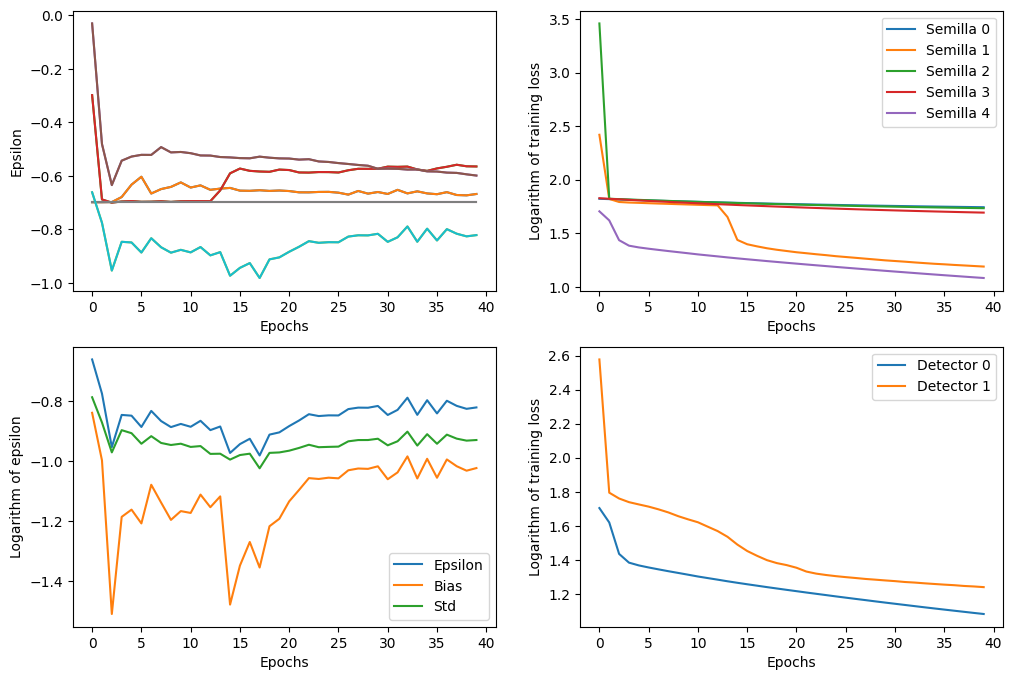

In [36]:
epsilon = np.array(epsilon, dtype='float64')
bias = np.array(bias, dtype='float64')
std = np.array(std, dtype='float64')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'float64')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'float64')

print(np.where(epsilon == np.min(epsilon)), np.min(epsilon))
index = 4
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
for i in range(epsilon.shape[0]):
  plt.plot(np.log10(epsilon[i,:]))
  plt.plot(np.log10(epsilon[i,:]))
plt.ylabel('Epsilon')
plt.xlabel('Epochs')

plt.subplot(2,2,2)
for i in range(training_loss_dec0.shape[0]):
  label = 'Semilla' + ' ' + str(i)
  plt.plot(np.log10(training_loss_dec0[i,:]),label=label)
  #plt.plot(np.log10(training_loss_dec1[i,:]),label=label)
plt.legend()
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')


plt.subplot(2,2,3)
plt.plot(np.log10(epsilon[index,:]), label= 'Epsilon')
plt.plot(np.log10(bias[index,:]), label = 'Bias')
plt.plot(np.log10(std[index,:]), label = 'Std')
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(2,2,4)
plt.plot(np.log10(training_loss_dec0[index,:]),label='Detector 0')
plt.plot(np.log10(training_loss_dec1[index,:]),label='Detector 1')
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')

plt.legend()


V82: CENTROID(ns) = 0.149  FWHM(ns) = 0.205  std(ns) = 0.087
V55: CENTROID(ns) = -0.001  FWHM(ns) = 0.244  std(ns) = 0.104
V28: CENTROID(ns) = -0.255  FWHM(ns) = 0.201  std(ns) = 0.085


Text(0, 0.5, 'Counts')

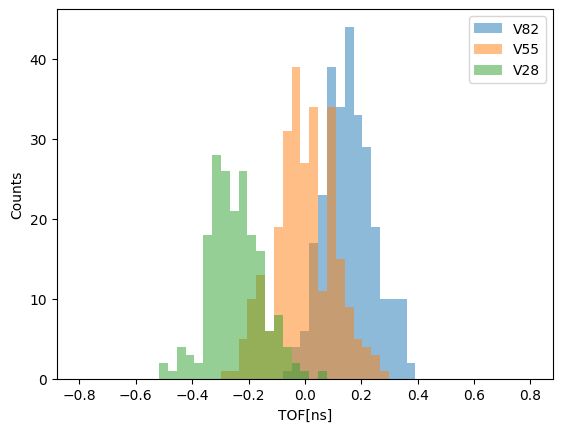

In [37]:
epoch = 17
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(TOFN_V82_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(TOFN_V55_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(TOFN_V28_array[index,epoch,:] - np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))
plt.xlabel('TOF[ns]')
plt.ylabel('Counts')